In [1]:
%pwd
%cd ../..

/Users/ryandevera/data-science/umn_environments/Deeplifting


In [2]:
from deeplifting.models import DeepliftingSkipMLP
from deeplifting.optimization import set_seed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

In [81]:
input_size = 512
hidden_sizes = (128, 128)
dimensions = 2
bounds = [(-10, 700), (-10, 700)]
activation = 'sine'
output_activation = 'sine'
agg_function = 'sum'
trial = 1

model = DeepliftingSkipMLP(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=dimensions,
    bounds=bounds,
    skip_every_n=1,
    activation=activation,
    output_activation=output_activation,
    agg_function=agg_function,
    seed=trial,
)

In [82]:
outputs1 = model(None)

In [83]:
outputs1 = pd.Series(outputs1[:, 0].detach().numpy())

In [84]:
outputs1.describe()

count    512.000000
mean       0.124701
std        0.188738
min       -0.442842
25%       -0.012376
50%        0.125912
75%        0.256332
max        0.697482
dtype: float64

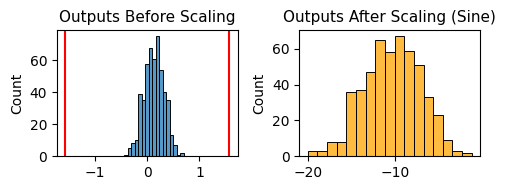

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2))

# Get the neural network outputs before scaling
sns.histplot(outputs1, ax=ax1)
ax1.set_title('Outputs Before Scaling', fontsize=11)
ax1.axvline(-np.pi / 2.0, color='r')
ax1.axvline(np.pi / 2.0, color='r')

# Get the neural network outputs after scaling
a, b = -30, 5
outputs1_scale = a + (b - a) / 2.0 * (outputs1.apply(np.sin) + 1)

sns.histplot(outputs1_scale, ax=ax2, color='orange')
ax2.set_title('Outputs After Scaling (Sine)', fontsize=11)

fig.tight_layout()
# fig.savefig(
#     '/Users/ryandevera/data-science/umn_environments/Deeplifting'
#     f'/images/scaling.png',
#     bbox_inches='tight',
#     pad_inches=0.01,
# )

In [105]:
outputs1_scale.describe()

count    512.000000
mean     -10.361143
std        3.225445
min      -19.998913
25%      -12.716573
50%      -10.302361
75%       -8.063160
max       -1.259932
dtype: float64

In [106]:
np.sinh(outputs1_scale).describe()

count    5.120000e+02
mean    -1.553658e+06
std      1.255897e+07
min     -2.423190e+08
25%     -1.666130e+05
50%     -1.490147e+04
75%     -1.587660e+03
max     -1.620753e+00
dtype: float64

In [107]:
np.sinh(5)

74.20321057778875